<a href="https://colab.research.google.com/github/routb68/hdlc/blob/main/fastText50_100D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model loading and Data loading

In [ ]:
import numpy as np
import pickle
from gensim.models import FastText
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
random.seed(10)
# model = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/50/fasttext/hi-d50-m2-fasttext.model')
# fasttext_transform = model.wv

#data loading and attaching religion
with open('/content/drive/MyDrive/Fairness in machine learning/HLDC   LDA preWork/df.pkl', 'rb') as file:
    df = pickle.load(file)

data, data_label = df['sentence_cleaned_split'], df['label']

muslim = {"अब्दुल", "अहमद", "आरिफ", "खां", "खालिद", "नदीम", "मुस्लिम", "मोहम्मद", "रिजवान", "सलीम" }
hindu = {"अमरजीत", "आर्य", "आशीष", "ओमकार", "किशोर", "कुलदीप", "जयराम", "धीरेन्द्र", "नितिन", "मुलायम", "राजपूत", "रामानन्द", "विजयपाल", "विमलेश", "श्रीराम"}


gt_data,gt_label,gt_reli = [],[],[]

num_hindu, num_muslim = 0,0
for i in range(10000):
  for x in data[i]:
     for y in muslim:
      if(x==y):
        gt_data.append(data[i]);
        gt_label.append(data_label[i])
        gt_reli.append(1)
        num_muslim += 1
        break;


     for y in hindu:
      if(x==y):
        gt_data.append(data[i]);
        gt_label.append(data_label[i])
        gt_reli.append(2)
        num_hindu += 1
        break;


org_gt_data,org_gt_label,org_gt_reli =gt_data,gt_label,gt_reli

gt_data,gt_label,gt_reli = [], [], []

cnt1, cnt2 = 0, 0

for i in range(len(org_gt_data)):
  if(org_gt_reli[i]==1 and cnt1<1010):
    gt_data.append(org_gt_data[i])
    gt_label.append(org_gt_label[i])
    gt_reli.append(org_gt_reli[i])
    cnt1+=1;
  elif (org_gt_reli[i]==2 and cnt2<1010):
    gt_data.append(org_gt_data[i])
    gt_label.append(org_gt_label[i])
    gt_reli.append(org_gt_reli[i])
    cnt2+=1;

print(cnt1)
print(cnt2)
print(len(gt_data))
len(org_gt_data)

1010
1010
2020


2779

#PCA function and w2v function

vector extrima min transformation

In [ ]:
def w2v_min_transform(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                                            #fastText_transform = model.word2vec,
                                                                            #dimension = dim of w2vec
                                                                            #num_data_points = 2020 for our case

  data_xx = []
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))
    for k in range(dimension):    #setting a bigger value to get min val in latter stage
      a[0][k] = 1e9
    for k in range(dimension):
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) > abs(c):
          a[0][k] = c
    data_xx.append(a)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec

vector extrima max transformation

In [ ]:
def w2v_max_transform(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                           #fastText_transform = model.word2vec,
                                                           #dimension = dim of w2vec
                                                           #num_data_points = 2020 for our case

  data_xx = []
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))

    for k in range(dimension):
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) < abs(c):
          a[0][k] = c
    data_xx.append(a)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec

reconstruction error function

In [ ]:
def re_error(n,pca_data,dimension,num_data):# n = number of principal component, x_data = pca_data,
                                            # dimension = fast text transformesd dimension
  total_cost, hindu_cost, muslim_cost = 0,0,0

  pca_data = preprocessing.StandardScaler().fit_transform(pca_data)

  #pca calculation
  cov_mat = np.cov(np.transpose(pca_data))
  eig_vals, eig_vecs = np.linalg.eig(cov_mat)
  idx = eig_vals.argsort()[::-1]
  eig_vals = eig_vals[idx]
  eig_vecs = eig_vecs[:,idx]

  # reconstruction error calculation
  # x = cost, z = accumulative cost wrt dimension
  x=0
  for i in range(num_data):
    x = 0
    z = np.zeros((1,dimension))
    for j in range(n):
      z += (((np.dot(np.transpose(pca_data[i]),eig_vecs[j]))) * eig_vecs[j])

    x += (np.linalg.norm (z - pca_data[i]))

    total_cost += x
    if gt_reli[i]==1:
      muslim_cost += x
    else :
      hindu_cost += x
  # print(total_cost)

  total_cost /= num_data
  hindu_cost /= (num_data/2)
  muslim_cost /= (num_data/2)

  return total_cost, hindu_cost, muslim_cost

#PCA reconstruction error for 50-dim fastText min vector extrima

In [ ]:
pca_data = w2v_min_transform(gt_data,fasttext_transform,2020,50)

In [ ]:
print(pca_data.shape)

(2020, 50)


In [ ]:
pca_data[0]

array([ 1.07709877e-03,  8.30160920e-04, -1.24376488e-03, -5.29757235e-04,
       -1.03868049e-04,  2.05982011e-03, -1.83660979e-03,  8.05126270e-04,
       -2.87996721e-04,  1.86692341e-03,  1.05186179e-03,  4.62971220e-05,
       -9.79432021e-04, -2.86958716e-03, -2.04483955e-03, -4.44780989e-03,
       -2.20323354e-03,  4.37608454e-03, -6.54245669e-04,  3.31250834e-03,
        2.42299889e-03, -2.37014098e-03, -8.45621061e-03, -5.71361324e-03,
        1.47180899e-05, -2.69899750e-03, -2.97536771e-03,  7.04783294e-03,
       -1.25982577e-03,  7.83319026e-03,  5.82185853e-03,  3.40172648e-03,
        2.65216059e-03, -2.58499029e-04, -6.27139211e-03, -1.85257508e-04,
        1.08902459e-03, -7.72859342e-03,  6.01321878e-03,  7.32210744e-03,
       -1.62703649e-03,  1.03536248e-03, -5.06747281e-03, -7.01799011e-03,
        2.63671880e-03, -8.63786135e-03,  8.49821372e-04,  3.25222802e-03,
       -9.28418431e-03, -6.25381130e-04])

In [ ]:
x1 = []
for i in range(1,50):
  x1.append(i)

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,50):
  re_t,re_h,re_m = re_error(i,pca_data,50,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[5.470829505974891, 5.420577667035358, 5.363284889323535, 5.299956352532726, 5.246370128556743, 5.187722590761171, 5.118681153265057, 5.055206101549089, 4.9977496700267166, 4.948098283574772, 4.880971962929335, 4.8277344258135395, 4.7617571346340855, 4.691204437444163, 4.627295782009654, 4.558998111778686, 4.479647521469079, 4.422545890212222, 4.345309712804964, 4.286703749542227, 4.217054282348759, 4.147399294324908, 4.06721068677044, 3.9998036128870504, 3.9256309882993103, 3.8404827361329277, 3.7508139466764483, 3.676809515737246, 3.6076404579792105, 3.5190641806816845, 3.434539286827362, 3.3626536558428004, 3.2680855412732965, 3.1742688005887816, 3.0645915066225244, 2.964635737573891, 2.855234315505097, 2.7407383916083474, 2.6375675691209928, 2.5077426197964785, 2.3798595586331874, 2.250304309192206, 2.115733003897379, 1.94948874497624, 1.7915562024380611, 1.5764631760708336, 1.3273377265048554, 1.1030941064901083, 0.6458729470044821]
[5.625816534577659, 5.569277680596516, 5.5126462

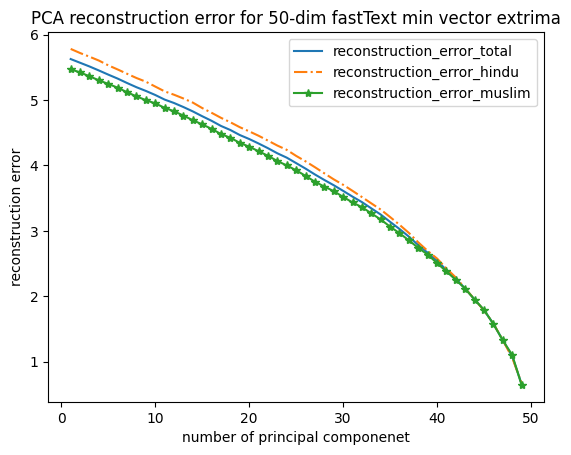

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 50-dim fastText min vector extrima')
plt.savefig("PCA reconstruction error for 50-dim fastText min vector extrima.png")
plt.show()

#PCA and Reconstruction error for 50-dim fastText max vec extrima

In [ ]:
pca_data = w2v_max_transform(gt_data,fasttext_transform,2020,50)
print(pca_data.shape)

(2020, 50)


In [ ]:
pca_data[0]

array([-1.2010287 , -1.2765826 ,  0.98640114,  1.05392003,  1.30456686,
       -2.18976593,  1.35549664, -1.14469612, -0.90612406,  0.96817648,
       -1.28930295,  0.85991973,  1.08092582, -0.94047266, -1.00494206,
        1.69116735, -1.13952339,  1.05759263,  1.01453066, -1.65191853,
       -1.0148977 ,  0.91679794, -1.35873425, -1.04121995,  1.13095045,
        1.24226391, -1.20315886, -1.1621604 ,  1.32178485, -1.12339246,
        1.04079223, -1.3295877 , -1.29140413, -1.2137984 , -1.17036879,
       -1.06714976,  1.01361358, -1.55359948,  0.9924162 ,  1.56769741,
       -1.48972476,  1.22116542, -1.63826978,  1.90437996, -1.41763031,
        0.92958516, -1.14849997,  1.13470614, -1.61597276, -1.20311987])

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,50):
  re_t,re_h,re_m = re_error(i,pca_data,50,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[6.606375870198106, 6.522805918940125, 6.435644704833296, 6.357330179107808, 6.28563813895655, 6.2296104296515304, 6.16043610630621, 6.080648497866481, 6.01460177424806, 5.938488103118073, 5.868735669634211, 5.793811223843419, 5.717358366861976, 5.627443626741641, 5.547941537889726, 5.471419637000567, 5.39376363775442, 5.311880130323188, 5.249404795587461, 5.174114081885971, 5.100999082684801, 5.024977965573671, 4.933306094703088, 4.865604256251491, 4.762231860391702, 4.6674174168627225, 4.5640294550898535, 4.4622784104378095, 4.361179949060886, 4.245325155773254, 4.130069688362715, 4.016728443606281, 3.9351732426423713, 3.758612077184933, 3.665676602696326, 3.5082774719630954, 3.356890120361313, 3.2051170382712395, 3.088217390733696, 2.9590990847637726, 2.822630570760548, 2.6098356758018264, 2.4221228101497974, 2.2236708751599545, 1.9948672021408438, 1.736996941681778, 1.474730532846063, 1.1402552026124342, 0.7809872013780784]
[6.704816836141582, 6.624135054293107, 6.544953791469382, 

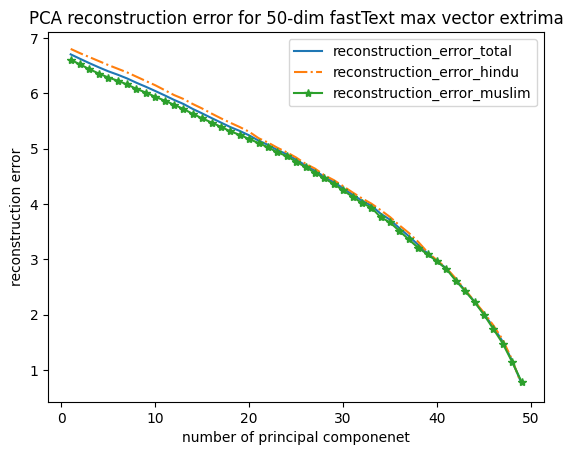

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 50-dim fastText max vector extrima')
plt.savefig("PCA reconstruction error for 50-dim fastText max vector extrima.png")
plt.show()

# fast text 100 dimension

In [ ]:
model100 = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/100/fasttext/hi-d100-m2-fasttext.model')
fasttext_transform100 = model100.wv

min vec extrima

In [ ]:
pca_data = w2v_min_transform(gt_data,fasttext_transform100,2020,100)
print(pca_data.shape)

(2020, 100)


In [ ]:
pca_data[0]

array([-7.64198776e-04, -2.05200375e-03,  2.03723367e-03, -1.97480549e-04,
        3.21455969e-04,  1.21124298e-03, -1.80775707e-03,  1.25328705e-04,
        1.25945138e-03, -7.10322696e-04, -1.09990442e-03, -5.25985146e-04,
        2.65740580e-03, -6.33239746e-04, -4.00255551e-04, -1.04899064e-03,
       -3.86488438e-03, -4.06521931e-03, -5.59187494e-03,  1.98370879e-04,
        1.23898193e-04, -2.07105908e-03,  9.85734072e-03, -4.17744415e-03,
       -3.90652521e-03, -1.43721967e-03, -1.30961626e-03,  2.23577023e-04,
       -2.42121960e-03,  3.57583584e-03,  1.45798700e-03, -1.90155406e-03,
       -1.28936765e-04, -5.01044618e-04, -1.04899157e-03,  5.39731991e-04,
       -3.35905468e-04, -6.35328889e-03, -1.20978698e-03, -2.05291132e-03,
       -1.91606791e-03,  1.06540986e-03, -8.94769561e-04, -1.05103187e-03,
        2.44227564e-03, -5.31729078e-04, -7.83562660e-04,  1.30565546e-03,
        6.16808711e-06, -1.30079582e-03, -1.06280495e-03,  9.01324383e-04,
       -2.69491225e-03, -

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,100):
  re_t,re_h,re_m = re_error(i,pca_data,100,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[8.095771760431619, 8.057825914246713, 8.024451777268233, 7.985805689386017, 7.945751186699354, 7.9055313904844615, 7.867219021560823, 7.8254000660716345, 7.776019192678947, 7.7349859962198755, 7.691614491562361, 7.653659739071431, 7.615574157952759, 7.573135993129974, 7.526721110391852, 7.486238582070905, 7.445991912043381, 7.405052112777734, 7.364715622210909, 7.319498350094413, 7.274487544307708, 7.226898735632043, 7.176159027547158, 7.132118483916278, 7.0882128859410205, 7.038809243714364, 6.988914820518391, 6.9436973639304655, 6.899862579739498, 6.852150980008326, 6.799078769144208, 6.746428992511801, 6.696102142230018, 6.649706050458213, 6.598038467130352, 6.552650547621428, 6.511072659982042, 6.454485392124266, 6.406046582669588, 6.343419117416278, 6.295249613181631, 6.239998709466363, 6.191252931126196, 6.143517185363396, 6.089886261078967, 6.0328930153602895, 5.982960134049461, 5.929414647858954, 5.875331252975333, 5.820270696713124, 5.757240647583528, 5.686612882969427, 5.621

In [ ]:
x1 = []
for i in range(1,100):
  x1.append(i)

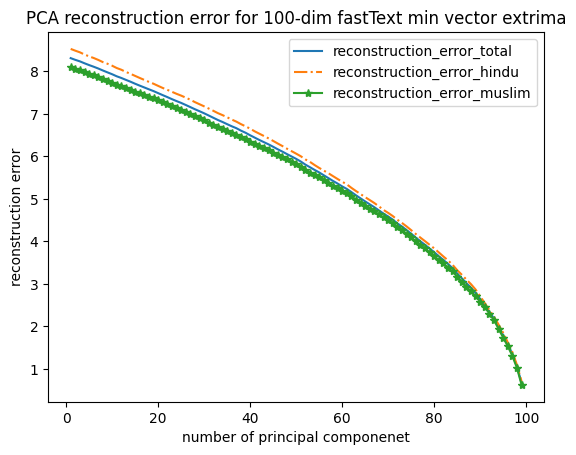

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 100-dim fastText min vector extrima')
plt.savefig("PCA reconstruction error for 100-dim fastText min vector extrima.png")
plt.show()

max vec extrima

In [ ]:
pca_data = w2v_max_transform(gt_data,fasttext_transform100,2020,100)
print(pca_data.shape)

(2020, 100)


In [ ]:
pca_data[0]

array([-1.27245522,  0.81457013,  0.86962807, -0.7662704 ,  0.67745048,
        1.27145243, -1.10148013,  0.79724681,  1.02799618,  0.92518467,
       -0.78557473, -0.8519209 , -0.76711887,  0.96652704,  0.72323567,
        0.8784771 , -0.83238518, -1.37432694, -0.93472159,  1.15410638,
       -0.91296721, -1.2170912 , -1.28989398, -0.89790255,  1.25988591,
        0.90290999, -1.27828574,  0.81347913, -0.93898225, -1.03919697,
        0.70911694,  0.65601671, -1.25310349, -0.81669557, -1.07235491,
        0.95127553,  0.90204942, -1.41280746, -1.32029772,  0.99138814,
        0.88504291, -0.88295603, -0.85286522, -0.81035948,  1.03282166,
        1.06521988,  1.07597256,  1.14555097,  0.89517212,  0.82245106,
        1.5201894 ,  1.33533144,  1.18544078, -0.8431831 ,  0.8477369 ,
        1.35343766,  0.81356227, -0.87624568,  1.01498067,  1.01275158,
       -1.11173427,  1.07031667, -0.97656518, -1.41956723,  1.16020358,
       -1.01347268, -1.31468439,  1.21540618,  1.15466273, -1.41

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,100):
  re_t,re_h,re_m = re_error(i,pca_data,100,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[9.324554700928516, 9.274613164892576, 9.232017124474893, 9.184730087282992, 9.133864142508596, 9.096148083318345, 9.049553038824696, 9.006743914778431, 8.946804595175472, 8.881884805603146, 8.817726921781242, 8.75139329047203, 8.703464708829527, 8.658302438732134, 8.61429558295851, 8.558094312942261, 8.514341987483682, 8.461948382227323, 8.412769189925633, 8.368399704478618, 8.319667772178317, 8.27105733306136, 8.211031209975207, 8.157886442824402, 8.0810966558233, 8.022948266579156, 7.967502512017974, 7.916609590887924, 7.855428661184914, 7.798968910997695, 7.72518186993849, 7.676716247982243, 7.6073320779084765, 7.550199868487645, 7.502314671245285, 7.433159218007617, 7.391749606160176, 7.3371616132810455, 7.278691693688883, 7.201226718259813, 7.123328004224391, 7.070958079244242, 7.020513271735044, 6.945932351896921, 6.889171727600415, 6.838438087972426, 6.771162046342015, 6.7040039634506225, 6.634840298727967, 6.552471302450721, 6.483076163398672, 6.4133077072078715, 6.35020398496

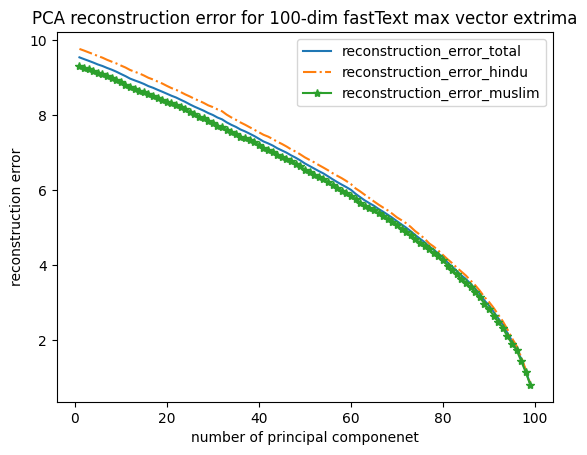

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 100-dim fastText max vector extrima')
plt.savefig("PCA reconstruction error for 100-dim fastText max vector extrima.png")
plt.show()

#fast Text 50 max min concatenation

In [ ]:
def concatenation_vec_generator(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                                                      #fastText_transform = model.word2vec,
                                                                                      #dimension = dim of w2vec
                                                                                      #num_data_points = 2020 for our case
  pca_data_min = w2v_min_transform(gt_data,fasttext_transform,num_data_points,dimension)
  pca_data_max = w2v_max_transform(gt_data,fasttext_transform,num_data_points,dimension)

  conca_vec = np.zeros((num_data_points,2*dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      conca_vec[i][j] = pca_data_min[i][j]
    for j in range(dimension, 2*dimension):
      conca_vec[i][j] = pca_data_max[i][j-dimension]

  return conca_vec

In [ ]:
conca_vec = concatenation_vec_generator(gt_data,fasttext_transform,2020,50)

In [ ]:
x1 = []
for i in range(1,100):
  x1.append(i)

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,100):
  re_t,re_h,re_m = re_error(i,conca_vec,100,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[8.889501029125888, 8.843038489353736, 8.790331955010087, 8.745510316616508, 8.700819313982503, 8.660487284473131, 8.60747876561984, 8.554837961334373, 8.49440093067341, 8.453366877578883, 8.401288148420813, 8.349743623508166, 8.294087452015516, 8.246471954362415, 8.173219866513955, 8.132174173180777, 8.08809514633218, 8.042552717741716, 7.990978092260691, 7.9372576333415505, 7.887441938525215, 7.837121750048273, 7.786678239599917, 7.741367225932445, 7.681970504832429, 7.624680706424392, 7.580548710832706, 7.53089171101634, 7.4739420059589365, 7.412856282533352, 7.350545373621399, 7.293426266341533, 7.242757103872837, 7.173294637321306, 7.110510457788958, 7.046220885667611, 6.993459341222512, 6.929519263184031, 6.855576560302288, 6.8001130239175085, 6.742525698697283, 6.683814804685912, 6.613590402233809, 6.561997474990912, 6.4964947180229755, 6.434682444232819, 6.36396201726154, 6.302806653354117, 6.2409636972541565, 6.179292437214247, 6.121985816691657, 6.067967962498647, 6.006931086

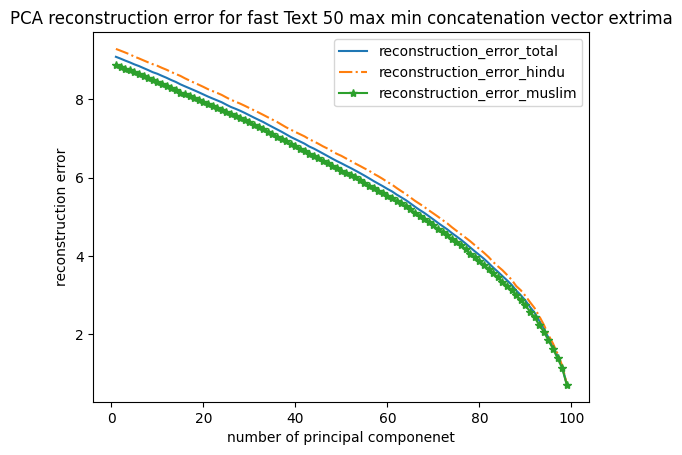

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for fast Text 50 max min concatenation vector extrima')
plt.savefig("PCA reconstruction error for fast Text 50 max min concatenation vector extrima.png")
plt.show()

#normalized pca error for 50 D

In [ ]:
def normalized_re_error(n,pca_data,dimension,num_data):# n = number of principal component, x_data = pca_data,
                                            # dimension = fast text transformesd dimension
  total_cost, hindu_cost, muslim_cost = 0,0,0

  pca_data = preprocessing.StandardScaler().fit_transform(pca_data)

  #pca calculation
  cov_mat = np.cov(np.transpose(pca_data))
  eig_vals, eig_vecs = np.linalg.eig(cov_mat)
  idx = eig_vals.argsort()[::-1]
  eig_vals = eig_vals[idx]
  eig_vecs = eig_vecs[:,idx]

  # reconstruction error calculation
  # x = cost, z = accumulative cost wrt dimension
  x=0
  for i in range(num_data):
    x = 0
    z = np.zeros((1,dimension))
    for j in range(n):
      z += (((np.dot(np.transpose(pca_data[i]),eig_vecs[j]))) * eig_vecs[j])

    temp1 = (np.linalg.norm (pca_data[i]))
    temp2 = (np.linalg.norm (z))
    x =  (temp2)/(temp1)


    total_cost += x
    if gt_reli[i]==1:
      muslim_cost += x
    else :
      hindu_cost += x
  # print(total_cost)

  total_cost /= num_data
  hindu_cost /= (num_data/2)
  muslim_cost /= (num_data/2)

  return total_cost, hindu_cost, muslim_cost

In [ ]:
pca_data = w2v_min_transform(gt_data,fasttext_transform,2020,50)


In [ ]:
x1 = []
for i in range(1,10):
  x1.append(i)

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,10):
  re_t,re_h,re_m = normalized_re_error(i,pca_data,50,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[0.8953898455630305, 0.8334131943515725, 0.7832237094667861, 0.7390339290270806, 0.6998875515701403, 0.6674529788843971, 0.6359168002584916, 0.608467781926642, 0.5846224679638904]
[0.894783828461937, 0.8297965484699014, 0.7815903361410077, 0.738383926913425, 0.6975449203616305, 0.6653549592042293, 0.6339267989906937, 0.6081922161574598, 0.585051011956961]
[0.8941778113608414, 0.8261799025882298, 0.7799569628152268, 0.7377339247997664, 0.6952022891531184, 0.6632569395240603, 0.6319367977228935, 0.6079166503882771, 0.5854795559500301]


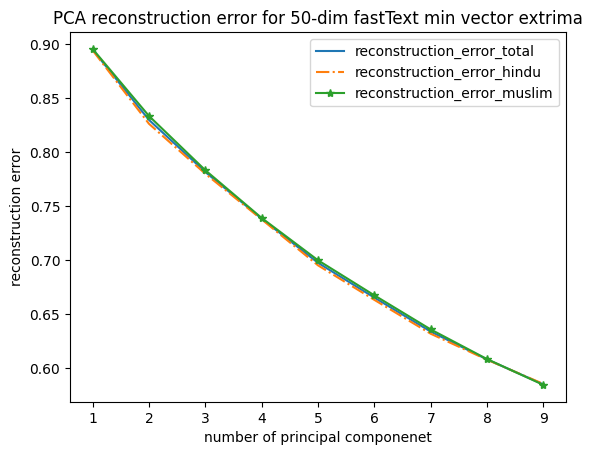

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 50-dim fastText min vector extrima')
plt.savefig("PCA reconstruction error for 50-dim fastText min vector extrima.png")
plt.show()

#clustring for fastText min-vectorExtrima dim = 50, C = {2,9}

In [ ]:
def w2v_min_transform_words(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                                            #fastText_transform = model.word2vec,
                                                                            #dimension = dim of w2vec
                                                                            #num_data_points = 2020 for our case

  data_xx, words = [],[]
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))
    for k in range(dimension):    #setting a bigger value to get min val in latter stage
      a[0][k] = 1e9
    dic = {}
    for k in range(dimension):
      w_idx = 0
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) > abs(c):
          a[0][k] = c
          w_idx = k1
      if gt_data[i][w_idx] in dic :
        dic[gt_data[i][w_idx]] += 1
      else :
        dic[gt_data[i][w_idx]] = 1
    data_xx.append(a)
    sorted(dic.items(), key=lambda _: _[1], reverse=True)
    cnt = 0
    temp1 = []
    for key in dic:
      temp1.append(key)
      cnt +=1
      if cnt > 10:
        break;
    words.append(temp1)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec,words

In [ ]:
data50_vec, words = w2v_min_transform_words(gt_data,fasttext_transform,2020,50)

In [ ]:
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data50_vec)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]

In [ ]:
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

In [ ]:
fairlet_cluster_stat

[[1010, 1009], [0, 1]]

In [ ]:
anamoly = 0
cnt = 0
for i in range(2020):
  if clusters[i]==1:
    cnt +=1
    anamoly = i

In [ ]:
print(cnt,anamoly)

1 1664


In [ ]:
words[1664]

['समर्थन', 'पैरोकारसगा', 'इापथपत्र', 'जोअभियुक्त', 'विमलेश']

In [ ]:
words[166]

['पर्यापतसाक्ष्य',
 '१७',
 'अभ्यस्थ',
 'अहमद',
 'ख',
 'कराया',
 'समाज',
 'सदस्यों',
 'उ०प्र०गिरोहबंद',
 'जिसकी',
 'विवेचनाउ०नि०']

In [ ]:
words[90]

['392,411',
 'अग्रेत्तर',
 '11082020',
 'संदिग्ध',
 'पूर्व',
 'माध्यम',
 'मारकरगिरा',
 'सोमेश',
 'सासनी',
 'कथन',
 'उफ']

In [ ]:
cluster_model = KMeans(n_clusters=3)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(3)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[455, 566], [555, 443], [0, 1]]


In [ ]:
anamoly = 0
cnt = 0
for i in range(2020):
  if clusters[i]==2:
    cnt +=1
    anamoly = i

print(anamoly)

1664


In [ ]:
cluster_model = KMeans(n_clusters=4)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(4)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[421, 543], [1, 0], [0, 1], [588, 466]]


In [ ]:
for i in range(2020):
  if clusters[i]==1:
    print(1,i)
  if clusters[i]==2:
    print(2,i)

1 1545
2 1664


In [ ]:
print(words[1545])

['बावत', 'नदीम', 'पक्ष', 'पेश', 'उपस्थित', '08', 'विद्वान्\\u200cअधिवक्ता', 'तरफ', 'उभय', 'श्रीअजय', '2019जमानत']


In [ ]:
cluster_model = KMeans(n_clusters=5)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(5)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[441, 380], [0, 1], [402, 433], [166, 196], [1, 0]]


In [ ]:
for i in range(2020):
  if clusters[i]==1:
    print(1,i)
  if clusters[i]==4:
    print(4,i)

4 1232
1 1664


In [ ]:
print(words[1232])

['समर्थन', 'अहमद', 'दिये', 'दाखिल', 'उपरोक्त', 'निरूद्धहै', 'तरफ', 'परवेज', 'सही', 'शपथ', 'दाखिलकरते']


In [ ]:
cluster_model = KMeans(n_clusters=6)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(6)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[583, 538], [191, 201], [0, 1], [234, 270], [1, 0], [1, 0]]


In [ ]:
for i in range(2020):
  if clusters[i]==2:
    print(2,i)
  if clusters[i]==4:
    print(4,i)
  if clusters[i]==5:
    print(5,i)

4 1232
5 1545
2 1664


In [ ]:
cluster_model = KMeans(n_clusters=7)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(7)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[145, 232], [1, 0], [33, 68], [0, 1], [179, 225], [651, 484], [1, 0]]


In [ ]:
for i in range(2020):
  if clusters[i]==1:
    print(1,i)
  if clusters[i]==3:
    print(3,i)
  if clusters[i]==6:
    print(6,i)

6 1232
1 1545
3 1664


In [ ]:
cluster_model = KMeans(n_clusters=8)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(8)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[32, 67], [559, 394], [170, 214], [0, 10], [247, 324], [1, 0], [1, 0], [0, 1]]


In [ ]:
cluster_model = KMeans(n_clusters=9)
clusters = cluster_model.fit_predict(data50_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(9)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[390, 388], [0, 1], [182, 193], [312, 301], [0, 10], [113, 113], [11, 4], [1, 0], [1, 0]]


#clustring for fastText min-vectorExtrima dim = 100, c = {2,9}

In [ ]:
model100 = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/100/fasttext/hi-d100-m2-fasttext.model')
fasttext_transform100 = model100.wv

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
data100_vec, words = w2v_min_transform_words(gt_data,fasttext_transform100,2020,100)

In [18]:
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[448, 446], [562, 564]]


In [19]:
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[562, 564], [448, 446]]


In [23]:
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[0, 1], [1010, 1009]]


In [24]:
for i in range(2020):
  if clusters[i]==0:
    print(0,i)

0 1664


In [25]:
cluster_model = KMeans(n_clusters=3)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(3)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[561, 559], [449, 450], [0, 1]]


In [26]:
for i in range(2020):
  if clusters[i]==2:
    print(2,i)

2 1664


In [29]:
cluster_model = KMeans(n_clusters=4)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(4)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[467, 508], [246, 271], [0, 1], [297, 230]]


In [30]:
for i in range(2020):
  if clusters[i]==2:
    print(2,i)

2 1664


In [32]:
cluster_model = KMeans(n_clusters=5)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(5)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[467, 505], [1, 0], [0, 1], [245, 274], [297, 230]]


In [33]:
for i in range(2020):
  if clusters[i]==1:
    print(1,i)
  if clusters[i]==2:
    print(2,i)

1 1545
2 1664


In [39]:
cluster_model = KMeans(n_clusters=6)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(6)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[340, 330], [165, 186], [0, 1], [1, 0], [325, 316], [179, 177]]


In [40]:
for i in range(2020):
  if clusters[i]==2:
    print(2,i)
  if clusters[i]==3:
    print(3,i)

3 1545
2 1664


In [43]:
cluster_model = KMeans(n_clusters=7)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(7)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[351, 355], [0, 1], [418, 404], [1, 0], [184, 201], [1, 0], [55, 49]]


In [44]:
for i in range(2020):
  if clusters[i]==1:
    print(1,i)
  if clusters[i]==3:
    print(3,i)
  if clusters[i]==5:
    print(5,i)

5 1232
3 1545
1 1664


In [47]:
cluster_model = KMeans(n_clusters=8)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(8)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1, 0], [373, 353], [0, 1], [12, 13], [231, 251], [98, 182], [294, 210], [1, 0]]


In [48]:
for i in range(2020):
  if clusters[i]==0:
    print(0,i)
  if clusters[i]==2:
    print(2,i)
  if clusters[i]==7:
    print(7,i)

7 1232
0 1545
2 1664


In [50]:
cluster_model = KMeans(n_clusters=9)
clusters = cluster_model.fit_predict(data100_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(9)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[34, 34], [441, 487], [0, 1], [217, 253], [1, 0], [1, 0], [0, 1], [296, 222], [20, 12]]


In [51]:
for i in range(2020):
  if clusters[i]==4:
    print(4,i)
  if clusters[i]==2:
    print(2,i)
  if clusters[i]==5:
    print(5,i)

5 1232
4 1545
2 1664


In [52]:
print(words[1232])

['निरूद्धहै', 'तरफ', 'समर्थन', 'शपथ', 'अहमद', 'दिये', 'प्रकरण', 'जेल', 'कथनों', 'परवेज', 'दाखिलकरते']


In [75]:
print(gt_data[1232])

['प्रकरण', 'उपरोक्त', 'जेल', 'निरूद्धहै', 'समर्थन', 'परवेज', 'अहमद', 'तरफ', 'शपथ', 'दाखिल', 'दाखिलकरते', 'दिये', 'कथनों', 'सही']


In [53]:
print(words[1545])

['पक्ष', 'तरफ', 'पेश', 'विद्वान्\\u200cअधिवक्ता', 'उभय', 'सुना', 'नदीम', 'बावत', 'उपस्थित', '2019जमानत', '02']


In [76]:
print(gt_data[1545])

['02', '08', '2019जमानत', 'बावत', 'नदीम', 'पेश', 'तरफ', 'विद्वान्\\u200cअधिवक्ता', 'तरफ', 'श्रीअजय', 'उपस्थित', 'उभय', 'पक्ष', 'सुना']


In [54]:
print(words[1664])

['जोअभियुक्त', 'समर्थन', 'पैरोकारसगा', 'इापथपत्र', 'विमलेश']


In [79]:
print(gt_data[1664])

['समर्थन', 'विमलेश', 'जोअभियुक्त', 'पैरोकारसगा', 'इापथपत्र']


#clustering for fastText max-vectorExtrima dim=100,C = {2,3,4}

In [55]:
def w2v_max_transform_words(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                                            #fastText_transform = model.word2vec,
                                                                            #dimension = dim of w2vec
                                                                            #num_data_points = 2020 for our case

  data_xx, words = [],[]
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))
    dic = {}
    for k in range(dimension):
      w_idx = 0
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) < abs(c):
          a[0][k] = c
          w_idx = k1
      if gt_data[i][w_idx] in dic :
        dic[gt_data[i][w_idx]] += 1
      else :
        dic[gt_data[i][w_idx]] = 1
    data_xx.append(a)
    sorted(dic.items(), key=lambda _: _[1], reverse=True)
    cnt = 0
    temp1 = []
    for key in dic:
      temp1.append(key)
      cnt +=1
      if cnt > 10:
        break;
    words.append(temp1)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec,words

In [56]:
data100_max_vec, words_max = w2v_max_transform_words(gt_data,fasttext_transform100,2020,100)

In [71]:
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data100_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[443, 506], [567, 504]]


In [65]:
cluster_model = KMeans(n_clusters=3)
clusters = cluster_model.fit_predict(data100_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(3)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[271, 278], [307, 321], [432, 411]]


In [73]:
cluster_model = KMeans(n_clusters=4)
clusters = cluster_model.fit_predict(data100_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(4)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[2, 14], [354, 337], [163, 113], [491, 546]]


In [74]:
for i in range(2020):
  if clusters[i]==0:
    print(i)
    print(words_max[i])

1049
['वएक', 'रंजिश', '©', 'संक्षेप', 'बरामद', 'छप्पर', 'गोवंश', 'बनायी', 'बाँट', 'इतिहास', 'कुल्हाड़ी']
1050
['वएक', 'रंजिश', '©', 'संक्षेप', 'बरामद', 'छप्पर', 'गोवंश', 'बनायी', 'बाँट', 'इतिहास', 'कुल्हाड़ी']
1080
['©', 'मास्टर', 'प्रपत्र', 'निष्पादित', 'मौके', 'आधारकार्ड', 'विरूद्ध', 'षडयंत्र', 'बतायी', 'मांगा', 'इतिहास']
1585
['©', 'अनपढ़', 'अभियुक्तों', '54', 'बरामद', 'पाट', 'अन्तगत', 'करायी', 'मेहनतकश', 'बजकर', 'दर्ज']
1610
['©', '\\', '27', 'मोहम्मद', 'वर्ष', 'पत्रों', 'अधिनियम', 'हसनाडीह', 'मुजफ्फरनगर', 'संतकबीरनगर', 'तौफीक']
1611
['©', '\\', '27', 'मोहम्मद', 'वर्ष', 'पत्रों', 'अधिनियम', 'हसनाडीह', 'मुजफ्फरनगर', 'संतकबीरनगर', 'तौफीक']
1665
['©', 'बेटा', 'तथ्यों', 'रहता', 'दिर्नोक', 'मन्ना', 'नामित', 'कुलदीप', 'इतिहास', 'कारित', 'रात']
1666
['©', 'बेटा', 'तथ्यों', 'रहता', 'दिर्नोक', 'मन्ना', 'नामित', 'कुलदीप', 'इतिहास', 'कारित', 'रात']
1667
['©', 'बेटा', 'तथ्यों', 'रहता', 'दिर्नोक', 'मन्ना', 'नामित', 'कुलदीप', 'इतिहास', 'कारित', 'रात']
1668
['©', 'बेटा', 'तथ्यों', 'रहता', 'दिर्नो

'©' may be the cause of anamoly (2,14) in clustering, similar things appeared in the c==2 and c == 3 sometimes

#clustering for fastText max-vectorExtrima dim=50,C = {2,3,4,5,6,7}

In [80]:
model = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/50/fasttext/hi-d50-m2-fasttext.model')
fasttext_transform = model.wv

In [81]:
data50_max_vec, words_max = w2v_max_transform_words(gt_data,fasttext_transform,2020,50)

In [85]:
cluster_model = KMeans(n_clusters=2)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(2)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[443, 537], [567, 473]]


In [89]:
cluster_model = KMeans(n_clusters=3)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(3)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[388, 388], [238, 112], [384, 510]]


In [93]:
cluster_model = KMeans(n_clusters=4)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(4)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[326, 390], [161, 110], [114, 63], [409, 447]]


In [96]:
cluster_model = KMeans(n_clusters=5)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(5)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[119, 181], [150, 70], [408, 369], [331, 376], [2, 14]]


In [97]:
for i in range(2020):
  if clusters[i]==4:
    print(i)
    print(words_max[i])

1049
['अभिरक्षा', '©', 'पंजीकृत', 'कुल्हाड़ी', 'परमांस', 'महिला', 'कथान', 'रंजिश', 'बरामद', 'किलोग्राम', 'करीब']
1050
['अभिरक्षा', '©', 'पंजीकृत', 'कुल्हाड़ी', 'परमांस', 'महिला', 'कथान', 'रंजिश', 'बरामद', 'किलोग्राम', 'करीब']
1080
['अभियुक्तके', '©', 'बॉट', 'व्यक्ति', 'बनवाया', 'बेचना', 'दिखाई', 'बताया', 'मामला', 'मौके', 'मास्टर']
1585
['न्यायाधीश', '©', 'गिराने', 'गोली', 'सत्र', 'जिले', 'सर्वथा', 'बताया', 'दर्ज', 'टीम', 'बजकर']
1610
['आदेश', '©', 'अम्बेडकरनगर', 'पशु', '\\', 'मुजफ्फरनगर', 'अतरौला', 'वर्ष', 'तुर्कपट्टी', 'तौफीक', 'निस्तारण']
1611
['आदेश', '©', 'अम्बेडकरनगर', 'पशु', '\\', 'मुजफ्फरनगर', 'अतरौला', 'वर्ष', 'तुर्कपट्टी', 'तौफीक', 'निस्तारण']
1665
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बजे', 'लिखवाने']
1666
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बजे', 'लिखवाने']
1667
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बज

In [98]:
fasttext_transform['©']

array([-4.4502273e-01,  2.7207162e+00,  2.8904908e+00,  1.5409820e+00,
        1.0540397e+00, -2.9590745e+00,  3.4554572e+00, -1.7680347e+00,
       -3.5561845e-02, -1.5542344e+00,  4.4324601e-01, -1.8334730e+00,
        2.1995625e-01,  7.3927957e-01,  1.8046850e-01,  2.2925346e+00,
       -1.4831460e+00, -4.8516339e-01, -1.4642321e+00, -1.5277002e+00,
        1.2208945e+00, -7.3122758e-01,  5.2647353e-03, -4.9016872e-01,
       -1.6618636e-01, -5.5841750e-01,  9.4246161e-01,  1.1489054e+00,
       -1.5101674e+00, -2.5537257e+00, -2.1950045e+00,  3.3685379e+00,
        1.3184285e+00, -2.7486577e+00, -7.7178466e-01, -3.0792396e+00,
       -1.1004215e+00,  1.6768632e+00,  8.8035691e-01, -1.2426320e+00,
        1.2017791e+00,  3.2938251e-01, -6.0112276e+00,  2.2859661e-01,
        2.2742679e+00,  2.2394598e+00,  4.6729267e-01,  8.4418291e-01,
        1.1013473e+00, -1.9573376e+00], dtype=float32)

In [99]:
fasttext_transform100['©']

array([ 1.0181823 , -0.6427228 , -1.0761545 ,  0.3237581 , -1.0491927 ,
       -0.78882474,  1.6886244 ,  3.0198946 , -1.6245247 ,  1.7015213 ,
        0.75098366, -2.0930898 ,  0.556183  ,  1.6104473 , -0.9720904 ,
       -0.2378916 ,  1.1778954 , -2.3406138 ,  0.14795497,  0.35722196,
        3.003496  ,  0.43386656, -0.17612776,  2.5319023 ,  0.27653825,
        0.3827622 , -1.5874802 , -0.24408561,  0.43974328,  1.2590599 ,
       -0.8374781 , -1.9142909 , -0.8312598 , -2.4234796 ,  0.679487  ,
        1.0463756 ,  0.72530735,  0.10706817, -2.6013286 ,  0.8479765 ,
       -1.1486624 ,  0.41369286, -0.17823222,  0.48435518,  2.042489  ,
        0.5617478 , -0.23916054, -0.05318616,  2.0220811 , -0.5014304 ,
       -0.05293231,  1.1135066 , -0.76076233,  0.56450003,  1.9261488 ,
        0.424216  , -0.9498665 ,  2.0853276 ,  0.39595664, -0.00480871,
        0.24095546,  3.0842884 ,  0.21426383,  1.2583991 , -3.1646495 ,
        0.13612215, -2.2236483 ,  1.0236353 ,  0.08047843,  0.62

In [102]:
cluster_model = KMeans(n_clusters=6)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(6)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[2, 14], [242, 273], [112, 60], [223, 263], [161, 86], [270, 314]]


In [103]:
for i in range(2020):
  if clusters[i]==0:
    print(i)
    print(words_max[i])

1049
['अभिरक्षा', '©', 'पंजीकृत', 'कुल्हाड़ी', 'परमांस', 'महिला', 'कथान', 'रंजिश', 'बरामद', 'किलोग्राम', 'करीब']
1050
['अभिरक्षा', '©', 'पंजीकृत', 'कुल्हाड़ी', 'परमांस', 'महिला', 'कथान', 'रंजिश', 'बरामद', 'किलोग्राम', 'करीब']
1080
['अभियुक्तके', '©', 'बॉट', 'व्यक्ति', 'बनवाया', 'बेचना', 'दिखाई', 'बताया', 'मामला', 'मौके', 'मास्टर']
1585
['न्यायाधीश', '©', 'गिराने', 'गोली', 'सत्र', 'जिले', 'सर्वथा', 'बताया', 'दर्ज', 'टीम', 'बजकर']
1610
['आदेश', '©', 'अम्बेडकरनगर', 'पशु', '\\', 'मुजफ्फरनगर', 'अतरौला', 'वर्ष', 'तुर्कपट्टी', 'तौफीक', 'निस्तारण']
1611
['आदेश', '©', 'अम्बेडकरनगर', 'पशु', '\\', 'मुजफ्फरनगर', 'अतरौला', 'वर्ष', 'तुर्कपट्टी', 'तौफीक', 'निस्तारण']
1665
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बजे', 'लिखवाने']
1666
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बजे', 'लिखवाने']
1667
['अभिरक्षा', '©', 'कैन्ट', 'व्यक्ति', 'झाड़ियोंमें', 'पोस्टमार्टम', 'मेहनत', 'शर्तों', 'करीब', 'बज

In [104]:
cluster_model = KMeans(n_clusters=7)
clusters = cluster_model.fit_predict(data50_max_vec)
# for each cluster [muslim, hindu]
fairlet_cluster_stat = [ [0,0] for _ in range(7)]
for i in range(2020):
  if gt_reli[i] == 1:
    fairlet_cluster_stat[clusters[i]][0] += 1
  elif gt_reli[i] == 2:
    fairlet_cluster_stat[clusters[i]][1] += 1

print(fairlet_cluster_stat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[188, 258], [167, 196], [258, 258], [171, 176], [144, 86], [80, 22], [2, 14]]
